# Определение возраста покупателей

***Описание проекта***

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
<br>
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.<br> В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [20]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Всего 7591 изображение. 

In [22]:
labels_sort = labels.sort_values(by='real_age', ascending=True)

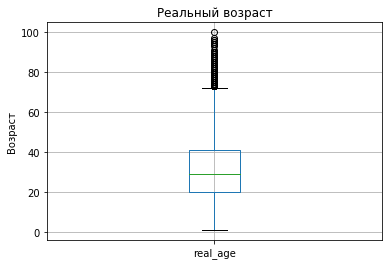

In [23]:
labels_sort.boxplot()
plt.title('Реальный возраст')
plt.ylabel('Возраст')
plt.show()

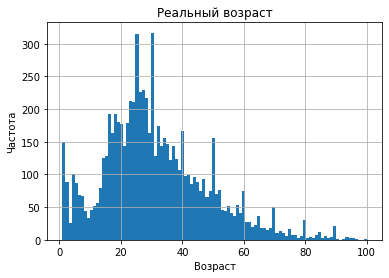

In [24]:
ax = labels_sort.hist(bins=100)
plt.title('Реальный возраст')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

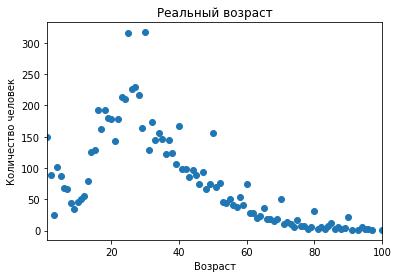

In [25]:
labels_sort['real_age'].value_counts().plot(style='o')
plt.title('Реальный возраст')
plt.xlabel('Возраст')
plt.ylabel('Количество человек')
plt.show()

In [26]:
features, target = next(train_gen_flow)

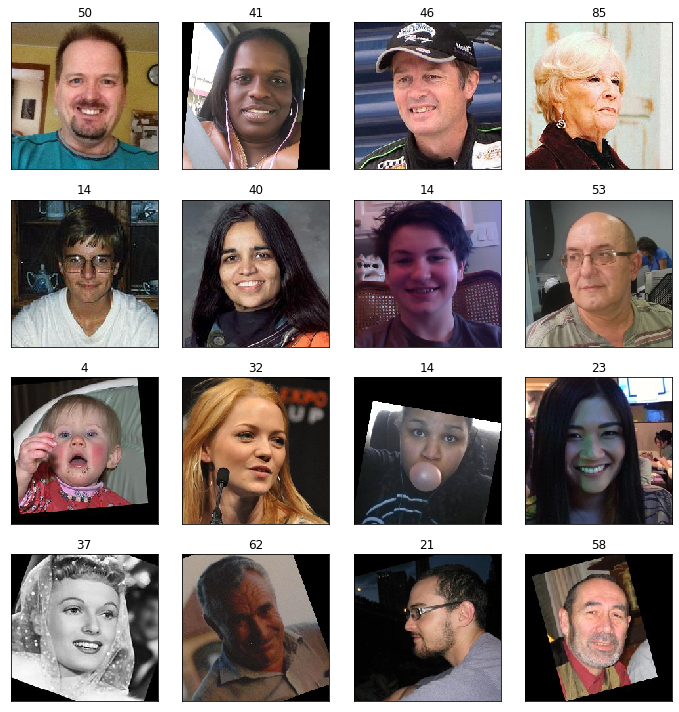

In [28]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])

1. Для анализа были получены фотографии покупателей, всего 7591 изображение. Выборка является достаточной для построения модели анализа возраста. <br>
2. Была построена гистограмма распределения значений реального возраста посетителей. Очень много значений равных 1. Скорее всего такой возраст приписывали младенцам и детям, не уточняя сколько им точно лет. Также после 20 лет есть пики каждые 10 лет, скорее всего это связано с тем, что люди округляли свой возраст до ближайшей "круглой даты", не указывая свой точный возраст. <br>
3. Большинство фотографий цветные, не все из них хорошего качества, некоторые повернуты под углом влево или вправо. Для анализа изображений можно применить отражение по горизонтали. Размер лиц на фотографиях отличается. Так, у ребенка и у взрослого человека размер лица может быть одинаковым.

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
 
def load_train(path):
    labels=pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1/255.)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow
 
def load_test(path):
    labels_test=pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels_test,
        directory=f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.000025)
    model.compile(optimizer=optimizer,loss='mse',
                  metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2021-05-18 13:16:52.754271: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-18 13:16:53.064915: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 450.0468 - mae: 16.0624 - val_loss: 950.2546 - val_mae: 26.0469
Epoch 2/10
178/178 - 43s - loss: 93.6729 - mae: 7.1925 - val_loss: 963.4346 - val_mae: 26.2874
Epoch 3/10
178/178 - 42s - loss: 56.6709 - mae: 5.7156 - val_loss: 563.3347 - val_mae: 18.5802
Epoch 4/10
178/178 - 42s - loss: 39.2506 - mae: 4.7263 - val_loss: 140.2528 - val_mae: 8.7419
Epoch 5/10
178/178 - 43s - loss: 30.0214 - mae: 4.1354 - val_loss: 110.5812 - val_mae: 8.1656
Epoch 6/10
178/178 - 42s - loss: 22.3135 - mae: 3.6238 - val_loss: 76.0082 - val_mae: 6.6540
Epoch 7/10
178/178 - 42s - loss: 19.9868 - mae: 3.3756 - val_loss: 71.8957 - val_mae: 6.3306
Epoch 8/10
178/178 - 42s - loss: 16.6421 - mae: 3.1438 - val_loss: 79.9818 - val_mae: 6.6940
Epoch 9/10
178/178 - 43s - loss: 14.6228 - mae: 2.9290 - val_loss: 70.0352 - val_mae: 6.2316
Epoch 10/10
178/178 - 42s - loss: 12.9640 - mae: 2.7723 - val_loss: 70.4802 - val_mae: 6.2730

```

## Анализ обученной модели

В ходе выполнения этого проекта был проведен исследовательский анализ набора данных. 
Всего в датасете 7591 изображение.
Была построена и обучена модель, которая определяет приблизительный возраст человека.
Качество МАЕ на валидационной выборке составило 6.27.